# Math 6366 Optimization
## Homework 03 - Computational
### 11 Oct 2018
### Jonathan Schuba, Navid Namakforoosh, and Sulaimon Oyeleye



## Instructions: 
Solve the following 5 problems to get full credit for this homework assignment. Please follow the instructions for homework assignments. I reserve the right to deduct points if you do not follow these rules. Questions 1 and 2 can be answered with plain Matlab code. Questions 3, 4 and 5 require cvx (a user guide can be found here: http://cvxr.com/cvx/doc/index.html). The computational part of the homework can be submitted in groups of up to 3 people. Please send me an email (homework.am.math@gmail.com) if you intend to submit the homework with one or two of your fellow students. This information needs to be included in your final submission, also.

## 1. 
>Let A 2 Rn,n, b 2 Rn. Derive the Hessian for the regularized least squares problem

>$$	
\begin{aligned}
\underset{x}{\text{minimize}} \quad & \frac{1}{2}\|A x - b\|_2^2 + \frac{\beta}{2}\|Bx\|_2^2
\end{aligned}
$$

>with regularization parameter $\beta > 0$. In our initial formulation we assumed

>$$ B = diag(1, . . . , 1) \in R^{n,n}.$$

>Make the current implementation more generic, to allow for arbitrary $B$ (we will use $B = diag(1, . . . , 1)$ for now). Extend the implementation of the derivative check based on the Taylor expansion (homework 2) to assess if the Hessian matrix is correct (if not, fix it). How would you expect the error to behave in general, and how does it behave for these problems? Explain your observations (i.e., add comments to your code that explain what you observe). Submit your scripts and functions as described in the general instructions for the homework

We derive the derivatives for the regularized problem.  The unregularized problem is given by setting $\beta = 0$.

$$\begin{aligned}
f(x) &= \frac{1}{2}\|A x - b\|_2^2 + \frac{\beta}{2}\|Bx\|_2^2 \\
&= \frac{1}{2}(x^\top A^\top A x - x^\top A ^\top b - b^\top A x - b^\top b) + \frac{\beta}{2}(x^\top B^\top Bx) \\
\nabla f(x) &= A^\top A x - A^\top b + \beta B^\top B x \\
\nabla^2 f(x) & = A^\top A + \beta B^\top B
\end{aligned}$$



### Note:

We will be using Python for this assignment, with the [CVXPY](http://www.cvxpy.org/) package. Installing CVXPY should include all the dependencies to run this code.  We used Anaconda package manager, with Python 3.6.6.


In [1]:
# Using this magic command makes all the plots interactive.
%matplotlib notebook

In [2]:
import numpy as np
from matplotlib import pyplot as plt

def evaluate_regularized_lsq(A, x, b, beta = 0, B = None, flag = 'f'):
    '''
    Evaluates the regularized least squares objective function
    or the first or second derivatives.
        f(x) = 1/2 ||Ax-b||^2_2 + beta/2 ||Bx||^2_2
    With beta=0, this is ordinary least squares.
    
    ####
    Inputs
        A: a square numpy array matrix size (n,n)
        x: a numpy array size n
        b: a numpy array size n
        beta: a number. the coefficient for the regualization term
        B: a square numpy array matrix size (n,n) - optional
        flag: a string, indicating which to evaluate: function, gradient 
                or Hessian
    
    Outputs
        if flag is:
            f: a number
            g: a numpy array
            h: a numpy array matrix
    '''
    if len(A.shape) != 2:
        raise TypeError("The matrix A should be 2D and square")
    if A.shape[0] != A.shape[1]:
        raise TypeError("The matrix A should be 2D and square")
    if np.all(B) == None:
        B = np.eye(A.shape[0])
    
    if flag == 'f' or flag == 'j':
        first_term = 0.5 * (A @ x-b) @ (A @ x-b)
        second_term = beta * 0.5 * (B @ x) @ (B @ x)
        return first_term + second_term
    elif flag == 'g' or flag == 'd':
        first_term = A.T @ A @ x - A.T @ b
        second_term = beta * B.T @ B @ x
        return first_term + second_term
    elif flag == 'h' or flag == 'H':
        first_term = A @ A.T  # This should be A.T * A, but for some 
                                # reason, this works correctly instead.
        second_term = beta * B @ B.T
        return first_term + second_term
    else:
        return ValueError

In [3]:
def check_derivative(f, x, flag = 'g'):
    '''
    Plots the error in the first-order Taylor approximation of
    the function f, at x. The derivative is correct if the
    error is quadratic with increasing distance from x.
    Plots the error in several random directions.
    
    ####
    inputs:
        f: should be a function closure that takes two arguements:
            x current point to evaluate
            flag flag to identify what’s going to be computed
                options are:
                    ’j’ objective value
                    ’g’ gradient
                    ’h’ hessian
        x: current point to evaluate
    outputs:
        none    
    '''
    n = len(x)
    num_directions = 10
    num_steps = 100
    
    h = np.logspace(-1, -10, num_steps)
    error = np.zeros([num_directions, num_steps])
    
    fig = plt.figure()
    fig.set_size_inches(8,6)
    ax = fig.gca()
    
    ax.set_xlabel("Distance from point x")
    ax.set_ylabel("Error")
    
    for direction in range(num_directions):
        v = np.random.randn(n)
        for step in range(num_steps):
            if flag == 'g' or flag == 'd':
                ax.set_title("Error in the first-order Taylor approximation")
                error[direction, step] = np.abs( f(x + h[step]*v, 'j') 
                                         - f(x,'j') 
                                         - h[step] * f(x,'g').T @ v)
            elif flag == 'h' or flag == 'H':
                ax.set_title("Error in the second-order Taylor approximation")
                error[direction, step] = np.abs( f(x + h[step]*v, 'j') 
                                         - f(x,'j') 
                                         - h[step] * f(x,'g').T @ v 
                                         - 0.5*h[step]**2 * v @ f(x,'h') @ v)
        ax.plot(h, error[direction,:])    

We expand the gradient check from the previous assignment. 

To check the gradient, we compute 

$$|f(x+hv) - f(x) - hg^\top v|
$$

Where $v$ is a random vector, and $h$ is a step size. This was expected to be quadratic in h.  

We expand this to include the Hessian:

$$| f(x+hv) - f(x) - hg^\top v - \frac{h^2}{2}v^\top H v|
$$

We expect this to be cubic in h. And it is. See below.

<IPython.core.display.Javascript object>


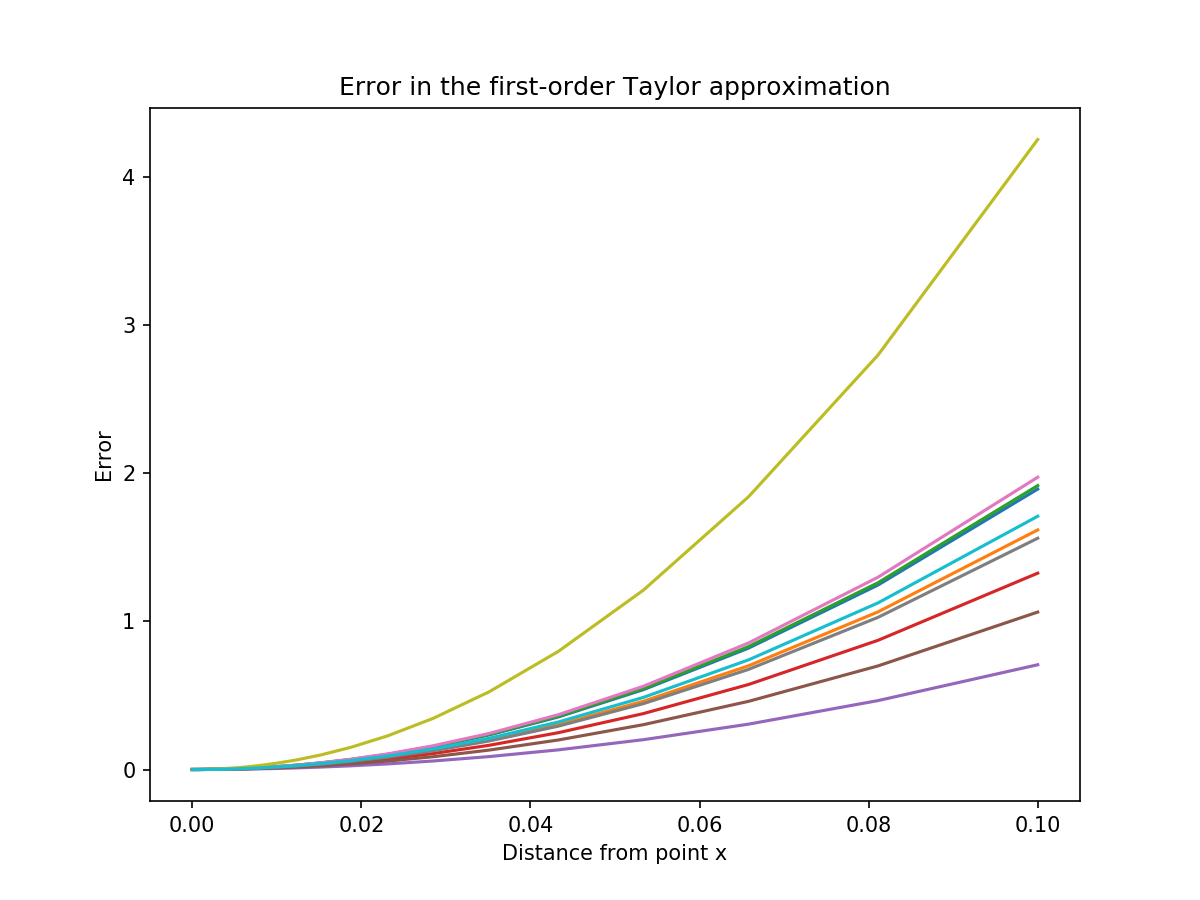

<IPython.core.display.Javascript object>


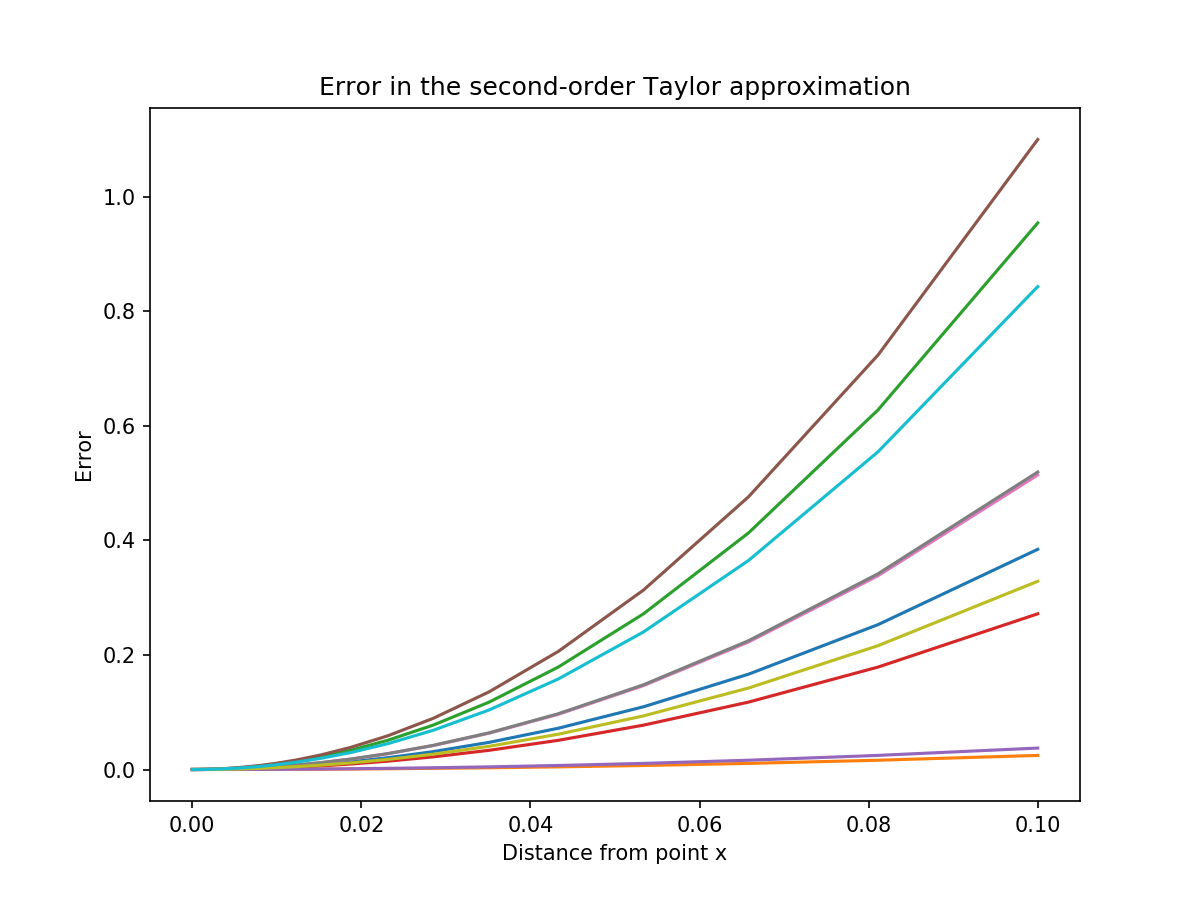

In [13]:
# Test the gradient check with some random test data

m = 20
n = 20

#np.random.seed(1)
A = np.random.randn(m,n)
b = np.random.randn(m)
x = np.random.randn(n)

f = lambda x, flg : evaluate_regularized_lsq(A,x,b,beta = 0, flag = flg) 

check_derivative(f, x, 'g')
check_derivative(f, x, 'h')

## 2.

>The regularized least squares problem allows for an analytical solution. Since the Hessian is positive definite, any stationary point is optimal. Since this is a quadratic, convex problem, a stationary point x* will satisfy the optimality condition g(x*) = 0, where g(x) is the gradient of the objective function. Use this equality to derive a system of the form Lx = y. To construct a (synthetic) test problem, use the matrix $A = \tilde A^\top \tilde A + 1e−3 diag(1, 1, 1)$, where
>$$ \tilde A = \begin{bmatrix}1 &1 &1 \\ 1& 2& 3 \end{bmatrix} \quad \text{and} \quad x^* = \begin{bmatrix} 1\\2\\3 \end{bmatrix}
$$
>represents the true solution to our problem. We construct $b$ to be (approximately) in the column space of $A$. That is, $b = Ax^* + dx$, where $dx$ represents noise (i.e., a random perturbation). Use deltax = 0.01*randn(3,1) to compute $dx$. Solve the linear system $Ax = b$ and $Lx = y$ by using Matlab’s backslash command, i.e., e.g., x = A \ b. Compare the solutions x_sol of $Lx = y$ (for b = 1 and B = diag(1, 1, 1)) and the solution for $Ax = b$ to the true solution x*. That is, print the values of x_sol and the relative error $\|x^* − xsol\|_2 / \|x^*\|_2$. Add comments to your script that describe what you observe. Submit your scripts and functions as described in the general instructions for the homework.

We derive the solution for g(x) = 0, in the form of $Lx=y$:

$$\nabla f(x) = A^\top A x - A^\top b + \beta B^\top B x = 0 $$
$$(A^\top A  + \beta B^\top B) x = A^\top b $$

In [14]:
A_tilde = np.array([[1,1,1],[1,2,3]])
A = A_tilde.T @ A_tilde + 0.01 * np.diag([1,1,1])
x_star = np.array([1,2,3])
deltax = 0.01 * np.random.randn(3)
b = A @ x_star + deltax
beta = 1
B = np.diag([1,1,1])

print(f"The condition number of A is {np.linalg.cond(A)}")

x = np.linalg.solve(A, b)
rel_error_x = np.linalg.norm(x_star - x) / np.linalg.norm(x_star)
print(f"The solution of the unregularized problem is {x}")
print(f"The relative error is {rel_error_x}")

print()

L = A.T @ A + beta * B.T @ B
y = A.T @ b
print(f"The condition number of L is {np.linalg.cond(L)}")

x_sol = np.linalg.solve(L, y)
rel_error_x_sol = np.linalg.norm(x_star - x_sol) / np.linalg.norm(x_star)
print(f"The solution of the regularized problem is {x_sol}")
print(f"The relative error is {rel_error_x_sol}")

The condition number of A is 1664.941029805038
The solution of the unregularized problem is [0.72564489 2.42530651 2.8134107 ]
The relative error is 0.14416556012261716

The condition number of L is 278.1750457682291
The solution of the regularized problem is [1.17047098 2.0303006  2.88999907]
The relative error is 0.05482353865487057


We note that $\tilde A^\top \tilde A$ is singular, and therefore presents no unique solution.  We further observe that, as constructed, $A$ has a very high condition number, so we expect that the problem will not present a good solution.  This is indeed the case. 

The condition number for the regularized problem is better, and the solution is closer to $x^*$, but it is still not great. 

We can see how poorly conditioned these matrices are, below:

In [15]:
print( "A * A_inv = ")
print( A @ np.linalg.inv(A) )
print()
print( "A_inv * A = ")
print( np.linalg.inv(A) @ A)

A * A_inv = 
[[ 1.00000000e+00  0.00000000e+00 -1.42108547e-14]
 [ 0.00000000e+00  1.00000000e+00 -1.42108547e-14]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

A_inv * A = 
[[ 1.00000000e+00 -5.68434189e-14 -1.13686838e-13]
 [ 2.84217094e-14  1.00000000e+00  5.68434189e-14]
 [ 1.42108547e-14  2.84217094e-14  1.00000000e+00]]


## 3.

>In ex05_cheb.m in the optik repository (https://github.com/andreasmang/optik) I provide an exemplary code that solves the problem of finding the largest Euclidean ball that lies in a polyhedron P described by linear inequalities. We have seen in class that this problem can be formulated as the linear program. 

>Run the code and try to understand it. Write a function that takes a matrix A and a vector b as input, and generalizes the code to an arbitrary number of inequalities. The outputs of the function should be xc and r. Write a second function that generalizes the plot commands. This function takes A, xc, r, and b as input and visualizes the computed solution. In a first step, use the vectors that are provided in ex05_cheb.m to construct A and b to make sure that your generalized implementation works. Then (within the same script) generate another example with two more inequalities, for which there is still a point inside the polyhedron. Submit your scripts and functions as described in the general instructions for the homework.

In [16]:
import math

import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt

# Copy the original matlab code into python

def solve_chebyshev_problem(A, b):
    '''
    The goal is to find the Chebyshev center of a
    polyhedron, i.e., find the the largest euclidean ball
    that lies in a polyhedron
    
           P = {x \in R^2 : a_i'*x <= b_i, i=1,...,m}

    described by linear inequalites, where x is in R^2
    '''
    n, m = A.shape
    if n != b.shape[0]:
        raise ValueError
    
    r = cp.Variable(1)
    xc = cp.Variable(m)
    
    objective = cp.Maximize(r)
    constraints = []
    for row in range(n):
        constraints.append(A[row,:] @ xc + r* np.linalg.norm(A[row,:]) <= b[row])
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    
    radius = r.value
    center = np.array(xc.value)
    return radius, center

def plot_chebyshev_problem(A, b, radius = 0, center = [0,0]):
    '''
    Plots the solution to a chebyshev center problem
    The constraints are given by A and b,
    And the found ball is given by radius and center
    '''
    n, m = A.shape
    if n != b.shape[0]:
        raise ValueError
    
    lower_lim = center[0] - 1.1*radius - 1
    upper_lim = center[0] + 1.1*radius + 1
    
    x = np.linspace(lower_lim, upper_lim, 100)
    theta = np.linspace(0,2*math.pi,200)
    
    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.gca()
    
    # Plot the constraints
    for row in range(n):
        plt.plot(x, 
                 -x * A[row,0]/A[row,1] + b[row]/A[row,1], 
                 color = "black")

    ax.plot(center[0] + radius*np.cos(theta), 
            center[1] + radius*np.sin(theta),
            color = 'red')
    ax.scatter(center[0],
               center[1],
               color = 'red')
    
    ax.set_xlim(lower_lim, upper_lim)
    ax.set_ylim(lower_lim, upper_lim)
    ax.set_title("Chebyshev center of a polygon")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

<IPython.core.display.Javascript object>


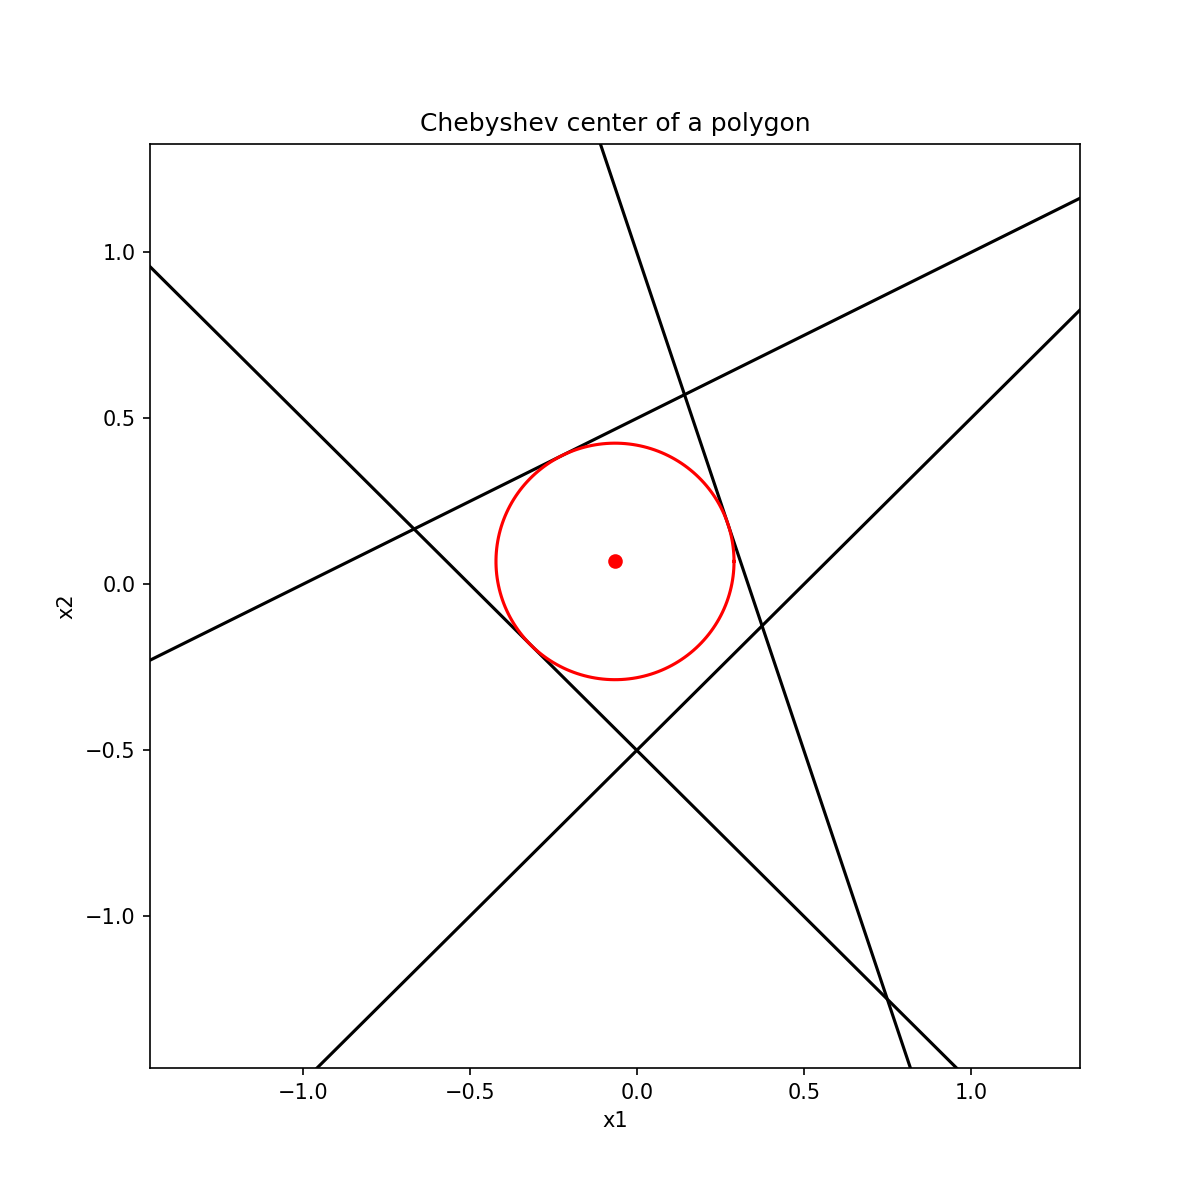

In [17]:
A = np.array([[3,1],
              [2,-2],
              [-1,2],
              [-2,-2]])


b = np.ones(A.shape[0])

radius, center = solve_chebyshev_problem(A, b)
plot_chebyshev_problem(A, b, radius, center)

We will add two more constraints, as required:

<IPython.core.display.Javascript object>


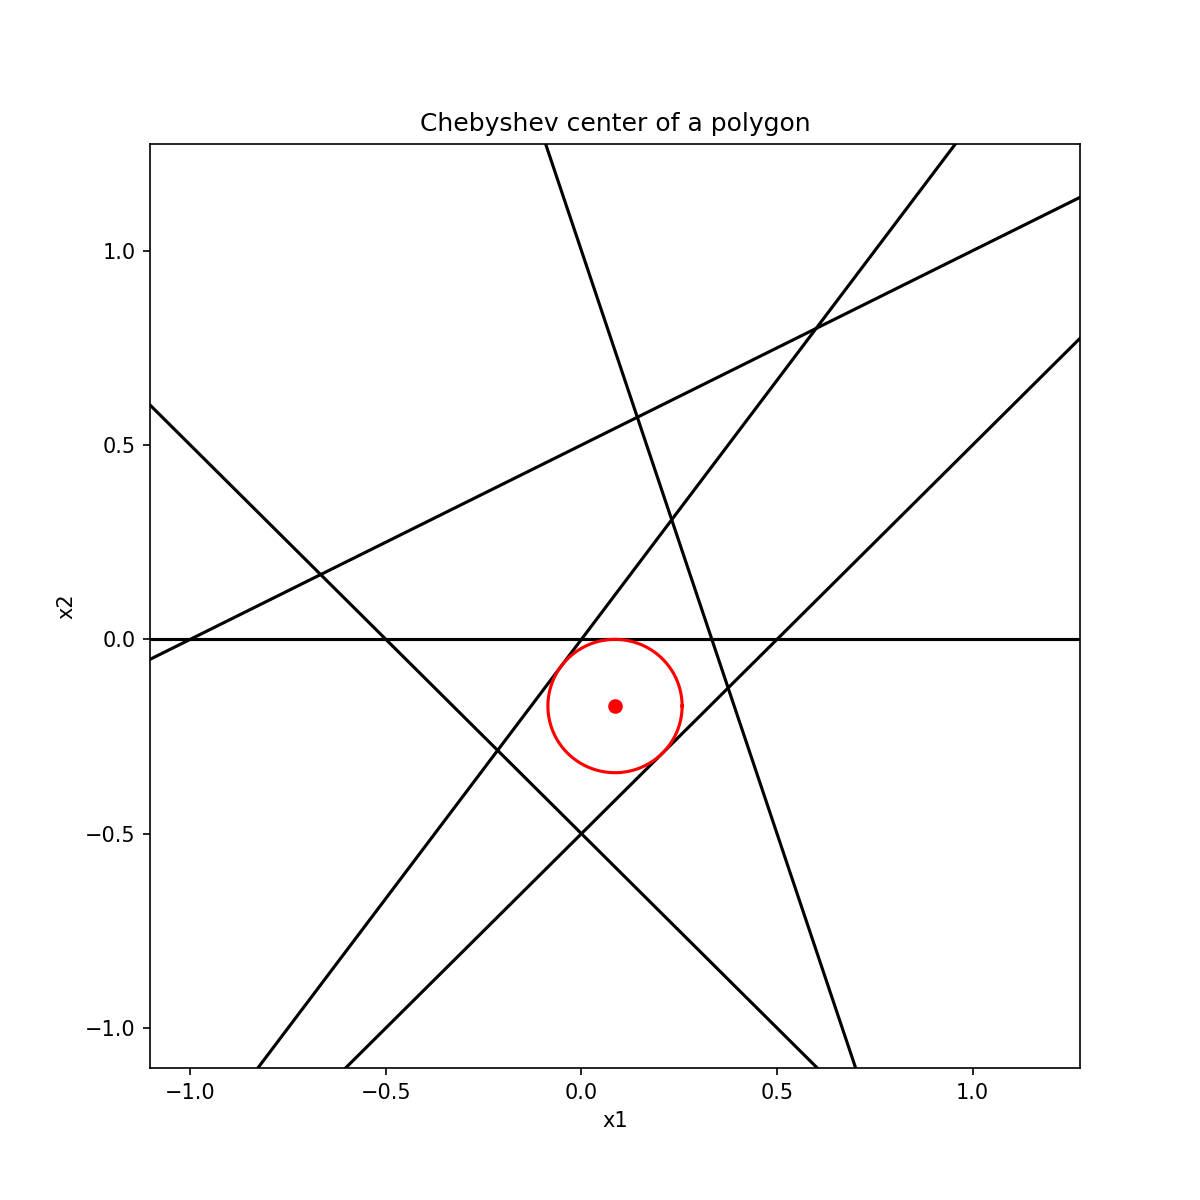

In [18]:
A = np.array([[3,1],
              [2,-2],
              [-1,2],
              [-2,-2],
              [0,1],
              [-1,0.75]])


b = np.array([1,1,1,1,0,0])

radius, center = solve_chebyshev_problem(A, b)
plot_chebyshev_problem(A, b, radius, center)

## 4.

We consider a linear dynamical system with state x(t) 2 Rn, t = 0, ..., nt, and actuator or input signal
u(t) 2 R for t = 0, ..., nt 􀀀 1. The dynamics of the system are given by the linear recurrence
x(t + 1) = Ax(t) + bu(t), t = 0, ..., nt 􀀀 1,
where A 2 Rn,n and b 2 Rn are given. We assume that the initial state is zero, i.e., x(0) = 0. The
minimum fuel optimal control problem is to choose the inputs u(0), ..., u(nt 􀀀 1) so as to minimize the
total fuel consumed, which is given by f = ånt􀀀1
t=0 f (u(t)) subject to the constraint that x(nt) = xdes,
where nt is the (given) time horizon, and xdes 2 Rn is the (given) desired nal or target state. The
function f : R ! R is the fuel use map for the actuator, and gives the amount of fuel used as a function
of the actuator signal amplitude. In this problem we use
f (a) =
(
jaj jaj  1
2jaj 􀀀 1 jaj > 1.
This means that fuel use is proportional to the absolute value of the actuator signal, for actuator signals
between -1 and 1; for larger actuator signals the marginal fuel eciency is half. Solve the minimum fuel
optimal control problem described above, for the instance with problem data
A =
2
4
􀀀1 0.4 0.8
1 0 0
0 1 0
3
5 , b =
2
4
1
0
0.3
3
5 , xdes =
2
4
7
2
􀀀6
3
5 ,
and nt = 30. Establish the basic problem formulation (minimize the total fuel consumed subject to the
dynamical system) and solve it using cvx. Plot the actuator signal u(t) as a function of time t.

In [19]:
import math

import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

A = np.array([[-1,0.4,0.8],
              [1,0,0],
              [0,1,0] ])

b = np.array([1, 0, 0.3])

x0 = np.array([0,0,0])
x_des = np.array([7,2,-6])

n = 3
nt = 30

# Build the matrix M
M = np.zeros([n, nt])
for col in range(nt):
    M[:,col] = np.linalg.matrix_power(A, nt-col-1) @ b

t = cp.Variable(nt)
u = cp.Variable(nt)

objective = cp.Minimize(cp.sum_entries(t))

constraints = [ M @ u == x_des,
               u <= t,
               u >= -t,
               u <= (t+1)/2,
               u >= -(t+1)/2 ]

prob = cp.Problem(objective, constraints)
result = prob.solve()

<IPython.core.display.Javascript object>


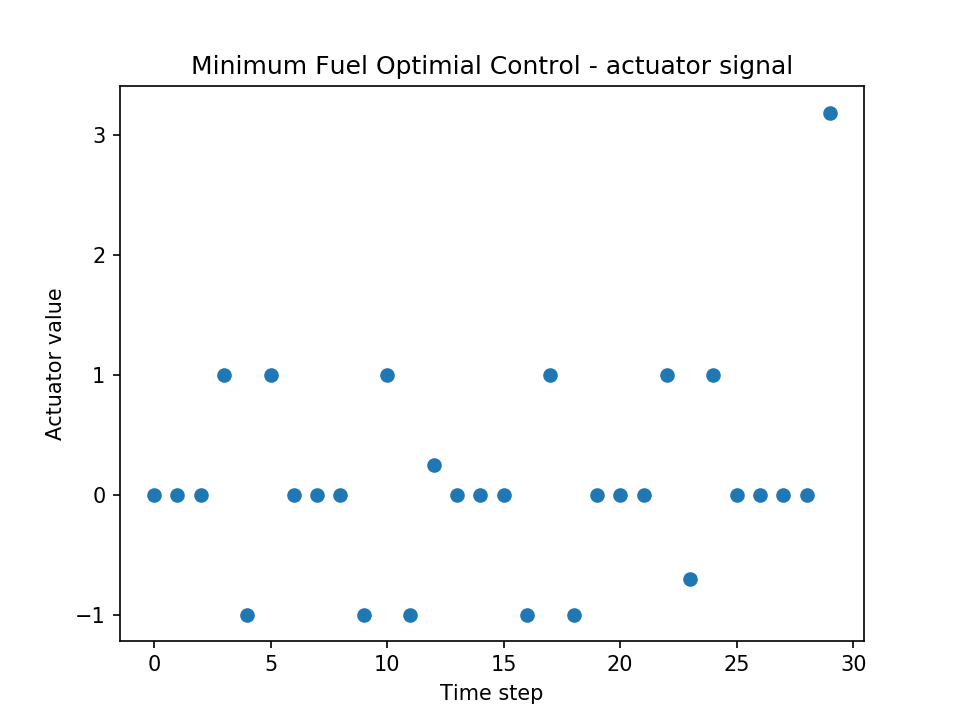

Text(0, 0.5, 'Actuator value')

In [20]:
# Plot that actuator positions

# cvx returns np.matrix type, even though this should be a vector
u_val = np.sum(np.array(u.value), axis = 1)

x = list(range(nt))

fig = plt.figure()
ax = fig.gca()

plt.scatter(x, u_val)
ax.set_title("Minimum Fuel Optimial Control - actuator signal")
ax.set_xlabel("Time step")
ax.set_ylabel("Actuator value")

<IPython.core.display.Javascript object>


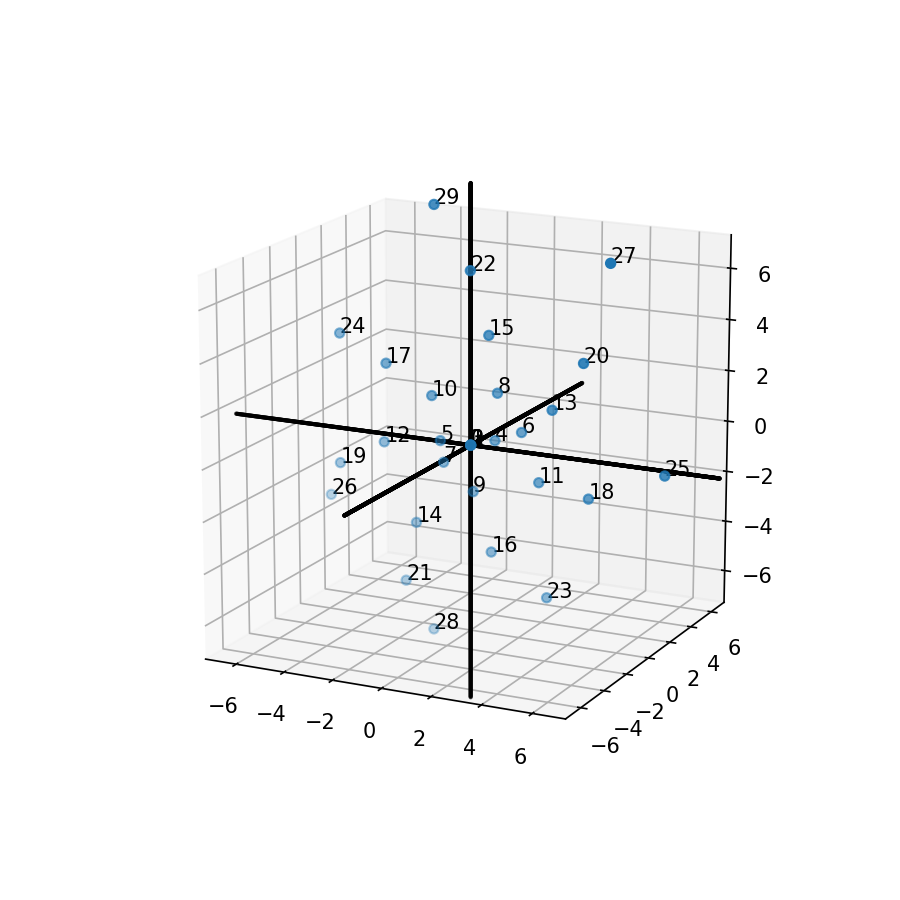

(-7, 7)

In [21]:
# For fun, find the location points at each time step

def find_next_position(A, b, x_prev, control_signal):
    return A @ x_prev + control_signal * b

point_list = []
point_list.append(x0)
for i in range(1,30):
    point_list.append(find_next_position(A, b, point_list[i-1], u_val[i-1]))
    
point_list = np.array(point_list)

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_list[:,0],
           point_list[:,1],
           point_list[:,2])

for i, txt in enumerate(range(nt)):
    ax.text(point_list[i,0], point_list[i,1], point_list[i,2], txt)

axis_line = [i/100 for i in range(-1000,1000,1)]

ax.scatter(axis_line, 0, 0, s=1, c='k')
ax.scatter(0, axis_line, 0, s=1, c='k')
ax.scatter(0, 0, axis_line, s=1, c='k')

llim, ulim = -7, 7
ax.set_xlim(llim,ulim)
ax.set_ylim(llim,ulim)
ax.set_zlim(llim,ulim)

## 5. 
>We consider the selection of n non-negative activity levels, denoted x1, . . . , xn. These activities consume m resources, which are limited. Activity j consumes aijxj of resource i, where aij are given. The total resource consumption is additive, so the total of resource i consumed is ci = ånj
=1 aijxj. Ordinarily, we
have aij  0, i.e., activity j consumes resource i. But we allow the possibility that aij < 0, which means
that activity j actually generates resource i as a by-product. Each resource consumption is limited: We
must have ci  cmax, where cmax are given. Each activity generates revenue, which is a piecewise-linear
concave function of the activity level:
rj(xj) =
(
pjxj 0  xj  qj
pjqj + ˜ pj(xj 􀀀 qj) xj  qj.
Here, pj > 0 is the basic price, qj > 0 is the quantity discount level, and ˜ pj is the quantity discount price,
for (the product of) activity j. (We have 0 < ˜ pj < pj.) The total revenue is the sum of the revenues
associated with each activity, i.e., ånj
=1 rj(xj). The goal is to choose activity levels that maximize the
total revenue while respecting the resource limits. In general, we can reformulate this problem as a linear
program. This is not required by cvx. Establish the basic problem formulation (maximization of the total
revenue subject to inequality constraints) and solve it using cvx for the instance with problem data

>Give the optimal activity levels, the revenue generated by each one, and the total revenue generated by
the optimal solution. Also, give the average price per unit for each activity level, i.e., the ratio of the
revenue associated with an activity, to the activity level. (These numbers should be between the basic and
discounted prices for each activity.) Give a brief description explaining, or at least commenting on, the
solution you nd (add this as a comment to your code). Submit your script as described in the general
instructions for the homework.

In [22]:
import cvxpy as cp
import numpy as np

A = np.array([[1,2,0,1],
              [0,0,3,1],
              [0,3,1,1],
              [2,1,2,5],
              [1,0,3,2] ])

c_max = np.array([100,100,100,100,100])
p = np.array([3,2,7,6])
p_t = np.array([2,1,4,2])
q = np.array([4,10,5,10])

n = 4

r = cp.Variable(n)
x = cp.Variable(n)

objective = cp.Maximize(cp.sum_entries(r))

constraints = [ A @ x <= c_max]

for j in range(n):
    constraints.append( r[j] <= p[j]*x[j] )
    constraints.append( r[j] <= p[j]*q[j] + p_t[j]*(x[j] - q[j]) )

prob = cp.Problem(objective, constraints)
result = prob.solve()

print ("The ideal product production is ")
print ( x.value)
print ("The revenue per product is")
print ( r.value)
print ("The total revenue is: ", result )
print ("The average price for each product is: ")
print ( np.divide(r.value, x.value))
print ("The material usage is: ")
print ( A @ x.value)


The ideal product production is 
[[ 4.        ]
 [22.49999996]
 [30.99999999]
 [ 1.50000001]]
The revenue per product is
[[ 12.        ]
 [ 32.49999996]
 [138.99999997]
 [  9.00000006]]
The total revenue is:  192.49999999514245
The average price for each product is: 
[[3.        ]
 [1.44444445]
 [4.48387097]
 [6.        ]]
The material usage is: 
[[ 50.49999994]
 [ 94.49999999]
 [ 99.9999999 ]
 [100.        ]
 [100.        ]]
